In [1]:
import torch, torchvision
import glob
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

from src.utils import *

plt.rcParams["figure.figsize"]= 16,8

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#### Load imges

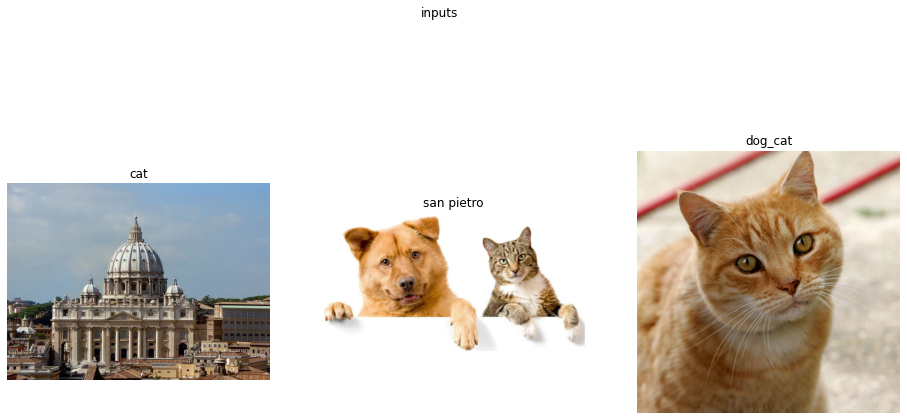

In [3]:
imgs_path = glob.glob('./data/*.*')
images = list(map(lambda x: Image.open(x), imgs_path))

subplot(images, title='inputs', rows_titles=['cat', \
                                             'san pietro','dog_cat'], nrows=1, ncols=3)

In [4]:
from torchvision.transforms import ToTensor, Resize, Compose, ToPILImage

inputs  = [Compose([Resize((224,224)), ToTensor(), image_net_preprocessing])(x).unsqueeze(0) for x in images]  # add 1 dim for batch
inputs = [i.to(device) for i in inputs]

In [5]:
# To clean the gpu cache
def free(modules):
    for m in modules:
        del m
    torch.cuda.empty_cache()

As we said, imagenet is a huge dataset with 1000 classes, represented by an integer not very human interpretable. We can associate each class id to its label by loading the imaganet2human.txt and create a python dictionary.

#### Load model

In [7]:
model = torchvision.models.alexnet(pretrained=True).to(device)

In [8]:
model_traced = module2traced(model, inputs[0])
model_traced

[Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
 AdaptiveAvgPool2d(output_size=(6, 6)),
 Dropout(p=0.5, inplace=False),
 Linear(in_features=9216, out_features=4096, bias=True),
 ReLU(inplace=True),
 Dropout(p=0.5, inplace=False),
 Linear(in_features=4096, out_features=4096, bias=True),
 ReLU(inplace=True),
 Linear(in_features=4096, out_features=1000, bias=True)]

In [29]:
model_traced[-1]

Linear(in_features=4096, out_features=1000, bias=True)

In [10]:
first_layer = model_traced[0]
first_layer

Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))

## Saliency visualization

One idea proposed by [Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps](https://arxiv.org/pdf/1312.6034.pdf) is to back-prop the output of the network with respect to a target class until the input and plot the computed gradient. This will highlight the part of the image responsible for that class. 


In [14]:
model.eval()
pred = model(inputs[2])
_, id = torch.max(pred, 1)

print(id)

tensor([282], device='cuda:0')


It will backproprop the output with respect to the one hot encoding representation of the number corresponding to `class tiger cat`


In [23]:
len(model_traced)

21

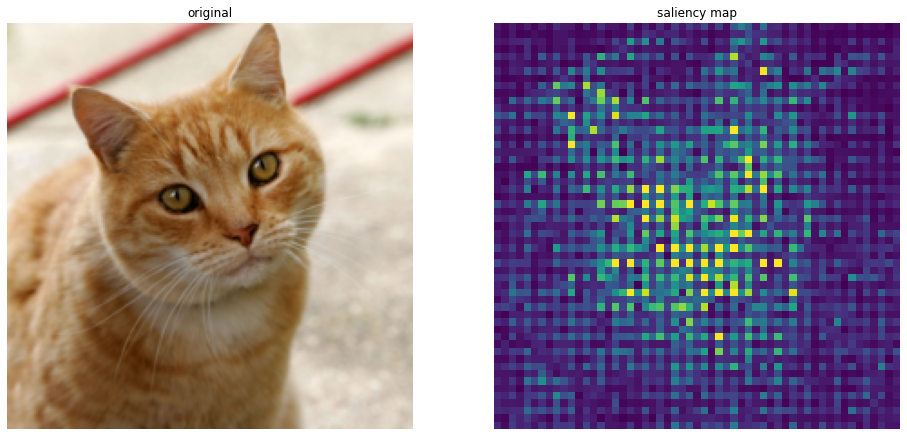

In [30]:
from src.SaliencyMap import SaliencyMap

model.eval()
model = model.to(device)
vis = SaliencyMap(model, device)

out, info = vis(inputs[2], model_traced[6])

subplot([image_net_postprocessing(inputs[2].squeeze().cpu()), out], 
        rows_titles=['original', 'saliency map'],
        parse=tensor2img, 
        nrows=1, ncols=2)

We can see that alexnet gets exited on the cat. We can even do better! We can set to `0` each negative relu gradient when backprop. This is techinique is called `guided`.

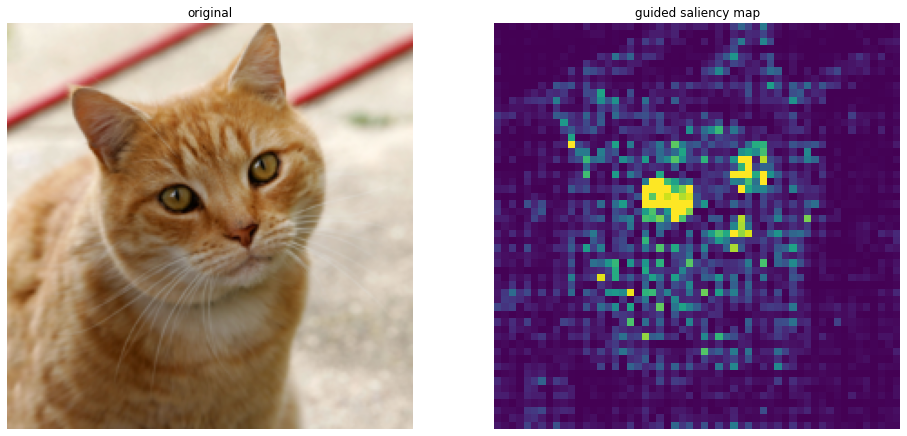

In [13]:
out, info = vis(inputs[2], 
          first_layer,
          guide=True)

subplot([image_net_postprocessing(inputs[2].squeeze().cpu()), out], 
        rows_titles=['original', 'guided saliency map'],
        parse=tensor2img, 
        nrows=1, ncols=2)

In [19]:
from torchvision.models import alexnet, vgg16, resnet34
modules_instances = [alexnet, vgg16, resnet34]


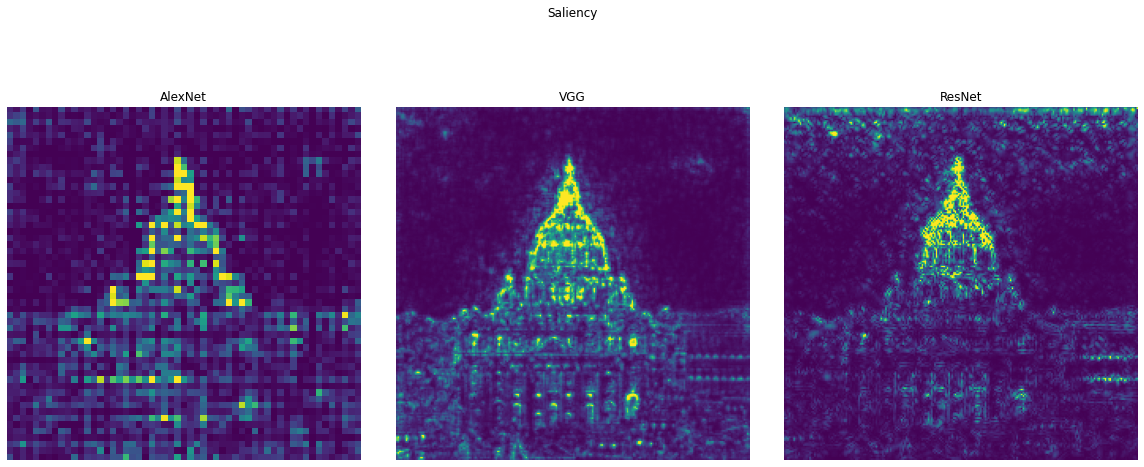

In [20]:
modules = (m(pretrained=True).to(device) for m in modules_instances) # make a generator, we don't want to store in memory all of them at once

run_vis_plot_across_models(modules, inputs[0], 0, SaliencyMap , 'Saliency', device, nrows=1, ncols=3, target_class=231, guide=True)

free(modules)

Alextnet seems more interested to the eyes, while VGG looks at the ears and resnet is similar to alexnet. Now we can clearly understand which part of the inputs help the network gives that prediction.
While guiding yields a better human interpretable image, the vanilla implementation can be used for localizing an object of interest. In other words, we can find object of interest for free by cropping out of the input image the region corresponding to the gradient. Let’s plot each input image for each model.

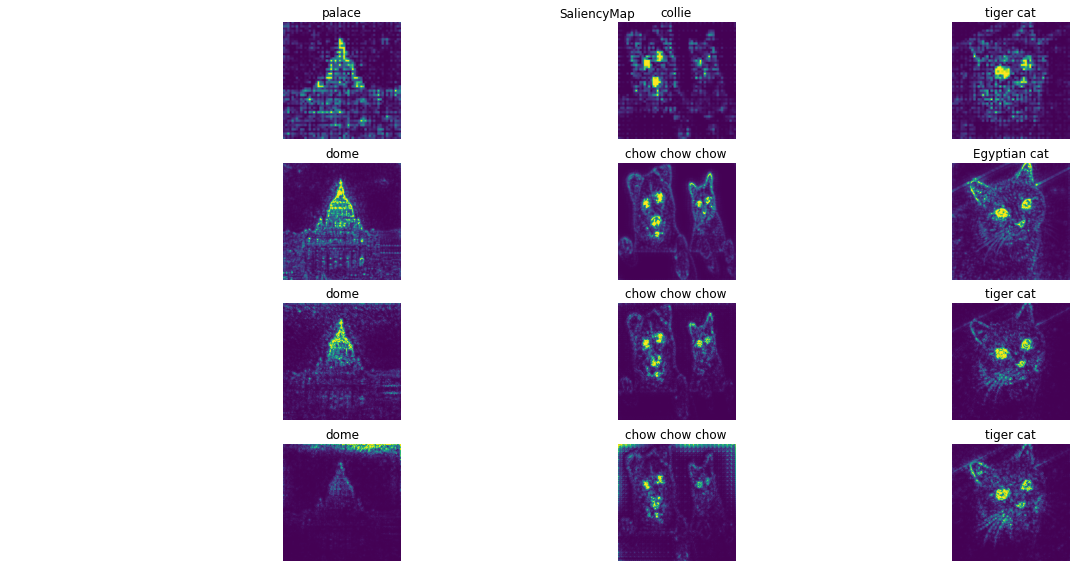

In [31]:
from torchvision.models import resnet34, resnet152 
modules_instances = [alexnet, vgg16, resnet34, resnet152]

modules = (m(pretrained=True) for m in modules_instances) # make a generator, we don't want to store in memory all of them at once


run_vis_plot_across_models(modules, inputs[0], None, SaliencyMap , 'SaliencyMap',  device,
                           nrows=4, 
                           ncols=3, 
                           inputs=inputs,
                           idx2label=imagenet2human,
                           annotations=['alexnet', 'vgg16', 'resnet34', 'resnet152'],
                           guide=True)

free(modules)

The Basilica is very interesting, all four networks correctly classify it as a dome but only resnet152 is more interested in the sky than on the cupola. In the last column, we have an image with two classes, dog and cat. All the networks highlighted booths, like the eyes of the dog and the ears of the cat in vgg16. What if we would like to discover only the region of the inputs that are related to a specific class? With this technique is impossible.
